# 3 Additional Functions with Keras

- 3.1 모델 합치기 with CIFAR10
- 3.2 데이터 증강
- 3.3 Finetuning
- 3.4 LSTM with MNIST
- 3.5 GAN with MNIST

## 3.1 모델 합치기 with CIFAR10

convolution과 maxpooling layer로 구성된 feature extractor 모델과

fully connected layer로 구성된 ANN classifier 모델을 따로 정의하고

두 모델을 합쳐서 CNN 모델을 만듬

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### (1) 데이터셋 : CIFAR 10

(50000, 32, 32, 3) (50000, 1)
label :  [6]
(50000, 32, 32, 3) (50000, 10)


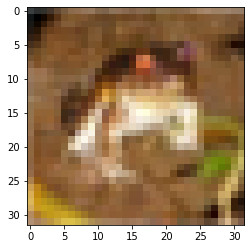

In [2]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets

# Dataset Load
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()

# Dataset Confirm
print(X_train.shape, Y_train.shape)
print('label : ',Y_train[0])
plt.imshow(X_train[0])

# Dataset Preprocessing
X_train = X_train/255.0
X_test = X_test/255.0
Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

### (2) 모델링

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [4]:
n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

def conv_maxpool_layers(n_in):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(n_in)))
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fc_layers(n_out):
    model = Sequential()
    model.add(Dense(units =128, input_shape=(2048,), activation='relu'))
    model.add(Dense(units =n_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def CNN_sum(n_in, n_out):
    
    # Coding Time
    
    #각 부분 모델
    feature_extractor=conv_maxpool_layers(n_in)
    feature_extractor.trainable=True # .trainable : 해당 layer에 대한 학습 여부 결정
    ann_classifier = fc_layers(n_out)
    ann_classifier.trainable=True
    
    #두 모델을 합쳐 새로운 모델 정의(Functional Style)
    x = Input(shape=n_in)
    feature = feature_extractor(x)
    y = ann_classifier(feature)
    model = Model(inputs = x, outputs = y)
    
    '''
    Sequential Style
    model = Sequential()
    model.add(feature_extractor)
    model.add(ann_classifier)
    '''
    return model

In [5]:
model = CNN_sum(n_in, n_out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 2048)              5088      
                                                                 
 sequential_1 (Sequential)   (None, 10)                263562    
                                                                 
Total params: 268,650
Trainable params: 268,650
Non-trainable params: 0
_________________________________________________________________


### (3-4) 모델의 학습과정 설정 / 모델 학습

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 4s 4ms/step - loss: 1.5893 - accuracy: 0.4303 - val_loss: 1.4090 - val_accuracy: 0.5092
Epoch 2/50
313/313 [==============================] - 1s 3ms/step - loss: 1.2460 - accuracy: 0.5593 - val_loss: 1.1851 - val_accuracy: 0.5897
Epoch 3/50
313/313 [==============================] - 1s 4ms/step - loss: 1.1125 - accuracy: 0.6115 - val_loss: 1.1012 - val_accuracy: 0.6157
Epoch 4/50
313/313 [==============================] - 1s 4ms/step - loss: 1.0255 - accuracy: 0.6420 - val_loss: 1.0436 - val_accuracy: 0.6378
Epoch 5/50
313/313 [==============================] - 1s 3ms/step - loss: 0.9598 - accuracy: 0.6658 - val_loss: 1.0397 - val_accuracy: 0.6356
Epoch 6/50
313/313 [==============================] - 1s 4ms/step - loss: 0.9054 - accuracy: 0.6844 - val_loss: 0.9942 - val_accuracy: 0.6543
Epoch 7/50
313/313 [==============================] - 1s 4ms/step - loss: 0.8518 - accuracy: 0.7044 - val_loss: 0.9827 - val_accuracy: 0.6627
Epoch 

### (5) 모델 평가

In [7]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 2ms/step - loss: 1.1221 - accuracy: 0.6652
loss : 1.1221, accruracy : 0.6652


## 3.2 Image data augmentation
케라스에서는 ImageDataGenerate 함수로 Data augmentation 기능을  제공

https://keras.io/preprocessing/image/#imagedatagenerator-class

### (1)-2 데이터 증강 적용

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [9]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 2, # 회전
    zoom_range = 0.1, # 확대 축소
    width_shift_range = 0.1, # 수평 이동
    height_shift_range = 0.1, # 수직 이동
    horizontal_flip = True, # 수평 반전|
    vertical_flip = False # 수직 반전
)

datagen.fit(X_train)

### (3-4) 모델의 학습과정 설정 / 모델 학습

In [10]:
model = CNN_sum(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
# Coding Time
model.fit(datagen.flow(X_train[:-10000], Y_train[:-10000], batch_size = 128), 
          epochs = 50, validation_data = (X_train[-10000:], Y_train[-10000:]), verbose = 1, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 9s 27ms/step - loss: 1.6988 - accuracy: 0.3882 - val_loss: 1.3886 - val_accuracy: 0.5116
Epoch 2/50
313/313 [==============================] - 8s 26ms/step - loss: 1.4005 - accuracy: 0.5023 - val_loss: 1.2685 - val_accuracy: 0.5595
Epoch 3/50
313/313 [==============================] - 9s 28ms/step - loss: 1.2870 - accuracy: 0.5454 - val_loss: 1.1312 - val_accuracy: 0.6088
Epoch 4/50
313/313 [==============================] - 8s 26ms/step - loss: 1.2080 - accuracy: 0.5753 - val_loss: 1.0758 - val_accuracy: 0.6271
Epoch 5/50
313/313 [==============================] - 8s 26ms/step - loss: 1.1610 - accuracy: 0.5882 - val_loss: 1.0749 - val_accuracy: 0.6286
Epoch 6/50
313/313 [==============================] - 8s 26ms/step - loss: 1.1162 - accuracy: 0.6057 - val_loss: 1.0839 - val_accuracy: 0.6221
Epoch 7/50
313/313 [==============================] - 8s 26ms/step - loss: 1.0760 - accuracy: 0.6214 - val_loss: 1.0425 - val_accuracy: 0.6426

In [11]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 2ms/step - loss: 0.8335 - accuracy: 0.7182
loss : 0.8335, accruracy : 0.7182


## 3.3 Transfer learning
Transfer learning을 통해 현재 쓰이고 있는 네트워크를 가져와 학습하는 방법을 배워본다(Classifier만 / Entire)

### (2) 모델링1 : Classifier learning
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [13]:
# Coding Time
base_model = VGG16(weights='imagenet', input_shape=(32,32,3), include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [15]:
# Coding Time
# Get Feature Extroactor from VGG16
x = base_model.output

# Add Classifier
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
predictions = Dense(Y_train.shape[1], activation='softmax')(x) #Y_train.shape[1] :10 

model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

### (3) 모델의 학습과정 설정

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습시키기

In [19]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 4s 11ms/step - loss: 1.7027 - accuracy: 0.4013 - val_loss: 1.4009 - val_accuracy: 0.5272
Epoch 2/50
313/313 [==============================] - 3s 10ms/step - loss: 1.5485 - accuracy: 0.4550 - val_loss: 1.3555 - val_accuracy: 0.5326
Epoch 3/50
313/313 [==============================] - 3s 10ms/step - loss: 1.5025 - accuracy: 0.4713 - val_loss: 1.3242 - val_accuracy: 0.5458
Epoch 4/50
313/313 [==============================] - 3s 10ms/step - loss: 1.4786 - accuracy: 0.4789 - val_loss: 1.2919 - val_accuracy: 0.5560
Epoch 5/50
313/313 [==============================] - 3s 10ms/step - loss: 1.4562 - accuracy: 0.4845 - val_loss: 1.2899 - val_accuracy: 0.5523
Epoch 6/50
313/313 [==============================] - 3s 10ms/step - loss: 1.4398 - accuracy: 0.4931 - val_loss: 1.2769 - val_accuracy: 0.5593
Epoch 7/50
313/313 [==============================] - 3s 10ms/step - loss: 1.4206 - accuracy: 0.4959 - val_loss: 1.2620 - val_accuracy: 0.5662

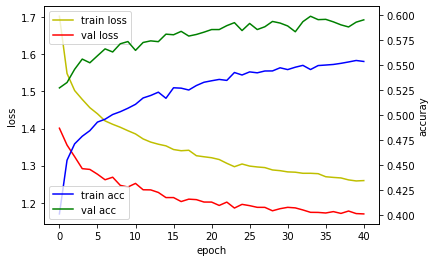

In [20]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [21]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 7ms/step - loss: 1.1857 - accuracy: 0.5860
loss : 1.1857, accruracy : 0.5860


### (2) 모델링1 : Entire
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [25]:
# Get Feature Extroactor from VGG16
x = base_model.output

# Add Classifier
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
predictions = Dense(Y_train.shape[1], activation='softmax')(x) #Y_train.shape[1] :10 

model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
# first: train the all layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

In [27]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

### (3) 모델의 학습과정 설정

In [28]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습시키기

In [29]:
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, Y_train, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
313/313 [==============================] - 8s 22ms/step - loss: 1.9678 - accuracy: 0.1904 - val_loss: 1.8984 - val_accuracy: 0.2118
Epoch 2/50
313/313 [==============================] - 6s 20ms/step - loss: 1.7000 - accuracy: 0.2874 - val_loss: 1.6063 - val_accuracy: 0.3678
Epoch 3/50
313/313 [==============================] - 6s 20ms/step - loss: 1.4222 - accuracy: 0.4316 - val_loss: 1.4205 - val_accuracy: 0.4629
Epoch 4/50
313/313 [==============================] - 6s 20ms/step - loss: 1.2089 - accuracy: 0.5426 - val_loss: 1.1417 - val_accuracy: 0.5714
Epoch 5/50
313/313 [==============================] - 6s 20ms/step - loss: 1.0502 - accuracy: 0.6117 - val_loss: 0.9998 - val_accuracy: 0.6414
Epoch 6/50
313/313 [==============================] - 6s 20ms/step - loss: 0.9180 - accuracy: 0.6669 - val_loss: 0.9878 - val_accuracy: 0.6619
Epoch 7/50
313/313 [==============================] - 6s 20ms/step - loss: 0.7917 - accuracy: 0.7142 - val_loss: 0.8184 - val_accuracy: 0.7031

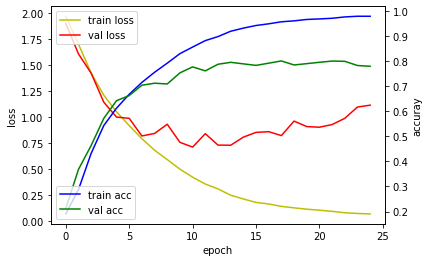

In [30]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [31]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 1s 7ms/step - loss: 0.8700 - accuracy: 0.7915
loss : 0.8700, accruracy : 0.7915


## 3.4 LSTM with MNIST

### (1) 데이터셋

In [32]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
(X_train, Y_train),(X_test, Y_test) = datasets.mnist.load_data()
X_train_norm = X_train.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0
Y_train_onehot = utils.to_categorical(Y_train)
Y_test_onehot = utils.to_categorical(Y_test)

print(X_train_norm.shape, Y_train_onehot.shape)
n_in = X_train.shape[1:]
n_out = Y_train_onehot.shape[-1]

(60000, 28, 28) (60000, 10)


### (2) 모델링

In [34]:
def lstm(n_in, n_out):
    # Coding Time
    model = Sequential()
    model.add(LSTM(30, input_shape=n_in))
    model.add(Dense(n_out, activation='softmax'))
    return model

model = lstm(n_in, n_out)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30)                7080      
                                                                 
 dense_10 (Dense)            (None, 10)                310       
                                                                 
Total params: 7,390
Trainable params: 7,390
Non-trainable params: 0
_________________________________________________________________


### (3) 모델의 학습과정 설정

In [35]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (4) 모델 학습

In [36]:
# Coding Time
earlystopper = EarlyStopping(monitor='val_accuracy', patience=7, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train_norm, Y_train_onehot, batch_size=128, epochs=50, validation_split=0.2, callbacks = [earlystopper])

Epoch 1/50
375/375 [==============================] - 3s 6ms/step - loss: 1.2620 - accuracy: 0.5872 - val_loss: 0.7396 - val_accuracy: 0.7692
Epoch 2/50
375/375 [==============================] - 2s 5ms/step - loss: 0.5858 - accuracy: 0.8203 - val_loss: 0.4616 - val_accuracy: 0.8624
Epoch 3/50
375/375 [==============================] - 2s 5ms/step - loss: 0.3927 - accuracy: 0.8798 - val_loss: 0.3123 - val_accuracy: 0.9054
Epoch 4/50
375/375 [==============================] - 2s 5ms/step - loss: 0.2997 - accuracy: 0.9094 - val_loss: 0.2512 - val_accuracy: 0.9247
Epoch 5/50
375/375 [==============================] - 2s 5ms/step - loss: 0.2408 - accuracy: 0.9271 - val_loss: 0.2195 - val_accuracy: 0.9341
Epoch 6/50
375/375 [==============================] - 2s 5ms/step - loss: 0.1995 - accuracy: 0.9397 - val_loss: 0.1798 - val_accuracy: 0.9465
Epoch 7/50
375/375 [==============================] - 2s 5ms/step - loss: 0.1705 - accuracy: 0.9493 - val_loss: 0.1568 - val_accuracy: 0.9533
Epoch 

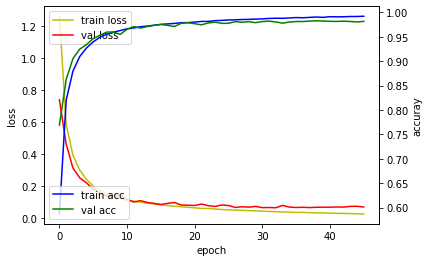

In [37]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### (5) 모델 평가하기

In [38]:
loss_and_accuracy = model.evaluate(X_test_norm, Y_test_onehot, batch_size=128, verbose=1)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0], loss_and_accuracy[1]))

79/79 [==============================] - 0s 2ms/step - loss: 0.0743 - accuracy: 0.9792
loss : 0.0743, accruracy : 0.9792


## 3.5 GAN with MNIST

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [40]:
from keras.layers import Input, Dense, Dropout, LeakyReLU
from keras.models import Model, Sequential
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras import initializers

In [41]:
# 실험을 재현하고 동일한 결과를 얻을 수 있는지 확인하기 위해 seed 를 설정합니다.
np.random.seed(10)

# 우리의 랜덤 노이즈 벡터의 차원을 설정합니다.
random_dim = 100

### (1) 데이터셋

In [42]:
def load_minst_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5 # -1~1 사이의 값
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test) # Label에 대한 진행이 없어도 됨

### (2-3) 모델링 / 모델 학습과정 설정

In [43]:
# Adam Optimizer를 사용합니다.
def get_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5)

# Generator 만들기
def get_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

# Discriminator 만들기
def get_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [44]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # Coding Time
    discriminator.trainable = False # Generator와 Discriminator를 동시에 학습시 trainable을 False로 설정

    gan_input = Input(shape=(random_dim,)) # gan_input : 노이즈(100 차원)

    x = generator(gan_input) # X:이미지

    gan_output = discriminator(x) # gan_output : 이미지가 진짜인지 아닌지에 대한 확률

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [45]:
# 생성된 MNIST 이미지 출력
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

### (4) 모델 학습

In [46]:
def train(epochs=1, batch_size=128):
    # train 데이터와 test 데이터를 가져옵니다.
    x_train, y_train, x_test, y_test = load_minst_data()

    # train 데이터를 128 사이즈의 batch 로 나눕니다.
    batch_count = x_train.shape[0] // batch_size

    # 우리의 GAN 네트워크를 만듭니다.
    adam = get_optimizer()
    generator = get_generator(adam)
    discriminator = get_discriminator(adam)
    gan = get_gan_network(discriminator, random_dim, generator, adam)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
            # Coding Time
            # 입력으로 사용할 random 노이즈와 이미지를 가져옵니다.
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generator를 통해 MNIST 이미지를 생성
            generated_images = generator.predict(noise, verbose =0)
            X = np.concatenate([image_batch, generated_images])

            # Discriminator 학습
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Generator 학습
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

--------------- Epoch 1 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:27<00:00, 17.27it/s]

4/4 [==============================] - 0s 3ms/step


--------------- Epoch 2 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.90it/s]


--------------- Epoch 3 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.90it/s]


--------------- Epoch 4 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.81it/s]


--------------- Epoch 5 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.68it/s]


--------------- Epoch 6 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.06it/s]


--------------- Epoch 7 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.65it/s]


--------------- Epoch 8 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.42it/s]


--------------- Epoch 9 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.15it/s]


--------------- Epoch 10 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.69it/s]


--------------- Epoch 11 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.71it/s]


--------------- Epoch 12 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.73it/s]


--------------- Epoch 13 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.82it/s]


--------------- Epoch 14 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.86it/s]


--------------- Epoch 15 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.67it/s]


--------------- Epoch 16 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:25<00:00, 18.15it/s]


--------------- Epoch 17 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.62it/s]


--------------- Epoch 18 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.80it/s]


--------------- Epoch 19 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.96it/s]


--------------- Epoch 20 ---------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [00:26<00:00, 17.77it/s]

4/4 [==============================] - 0s 2ms/step


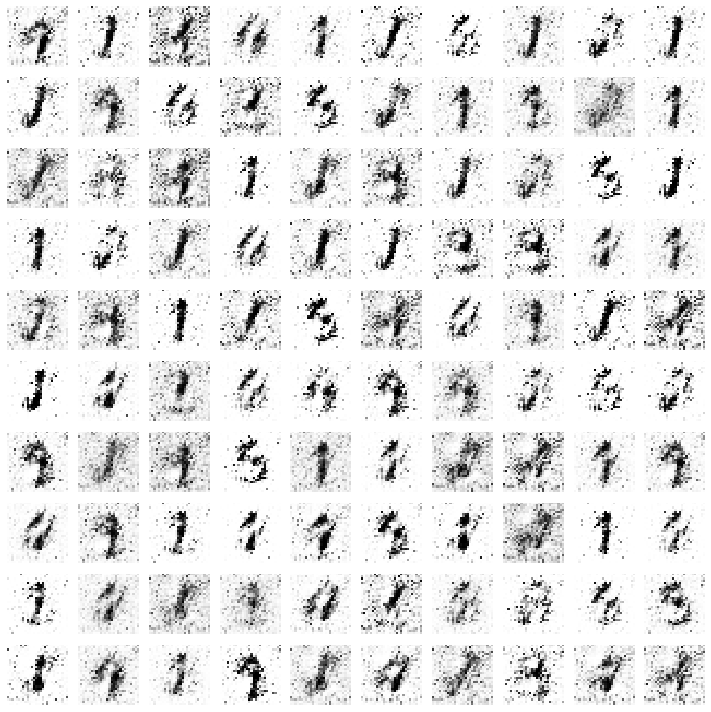

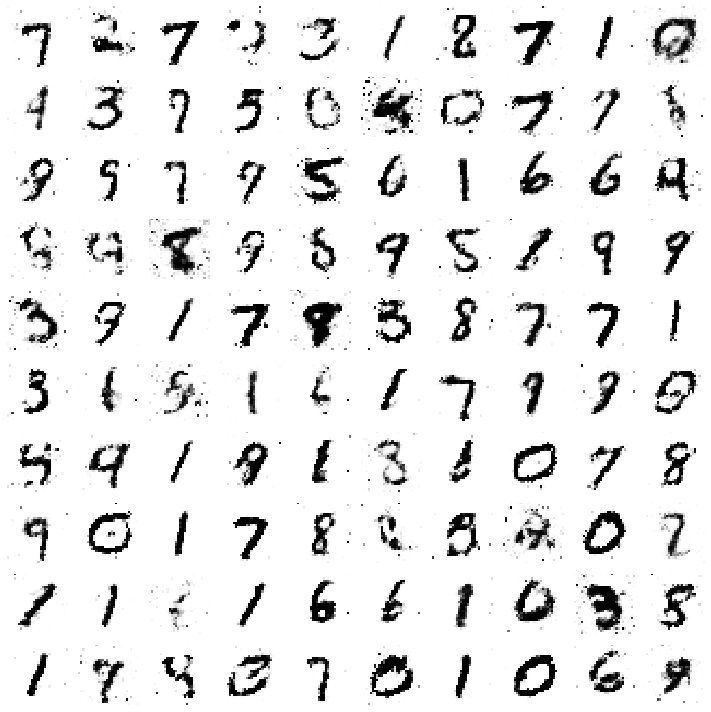

In [47]:
train(20, 128)